In [1]:
#hide
#default_exp dev.mapgen

# Map Generation

This notebook shows the development of the code required to generate the live map of energy generation by power plant.

<br>

### Imports

In [2]:
#exports
import json
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import typer
from tqdm import tqdm
from jinja2 import Template

from ElexonDataPortal.dev import utils, raw

In [3]:
from IPython.display import JSON
import matplotlib.pyplot as plt

<br>

### Network Route Map

The raw network route map data can be retrieved from [here](https://www.nationalgrid.com/uk/electricity-transmission/network-and-infrastructure/network-route-maps). We want to extract the relevant data, group the different cables/lines according to capacity, then save the information as a geojson.

In [4]:
#exports
def clean_route_gdf(gdf):
    s_LV_routes = gdf['OPERATING_'].astype(float).fillna(0)<=132
    gdf.loc[s_LV_routes, 'OPERATING_'] = '<=132'
    gdf.loc[~s_LV_routes, 'OPERATING_'] = gdf.loc[~s_LV_routes, 'OPERATING_'].astype(int).astype(str)
    
    return gdf

def load_route_gdf(data_dir='data'):
    gdf_OHL = gpd.read_file(f'{data_dir}/transmission-system/OHL.shp').to_crs('EPSG:4326')
    gdf_cables = gpd.read_file(f'{data_dir}/transmission-system/Cable.shp').to_crs('EPSG:4326')

    gdf_OHL = clean_route_gdf(gdf_OHL)
    gdf_cables = clean_route_gdf(gdf_cables)
    
    gdf_route = gdf_OHL.append(gdf_cables)[['OPERATING_', 'geometry']].rename(columns={'OPERATING_': 'kV'})
    gdf_route.to_file(f'{data_dir}/network_routes.json', driver='GeoJSON')
    
    return gdf_route

In [5]:
gdf_route = load_route_gdf('../data')

gdf_route.head(3)

,kV,geometry
0,400,"LINESTRING Z (-2.02839 51.85078 0.00000, -2.02..."
1,400,"LINESTRING Z (-2.02754 51.84931 0.00000, -2.02..."
2,400,"LINESTRING Z (-3.12672 51.20292 0.00000, -3.12..."


<br>

We'll quickly visualise the network route and count how many of the different capacity types we have.

275      1858
400      1232
<=132    1087
Name: kV, dtype: int64

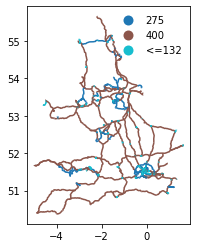

In [6]:
gdf_route.plot(column='kV', legend=True, legend_kwds={'frameon': False})

gdf_route['kV'].value_counts()

<br>

### Power Plant Output Data Retrieval

We'll begin by creating a function to retrieve and clean Physical Notification (PN) data for transmission level plants in Great Britain.

In [7]:
#hide
# loads the api_key into an environment variable - delete this cell if passing as string
from dotenv import load_dotenv

assert load_dotenv('../.env'), 'Environment variables could not be loaded'
api_key = os.environ['BMRS_API_KEY']

In [8]:
#exports
def construct_df_PN_pivot_dt_rng(df_PN):
    no_seconds = (((df_PN['timeFrom'].str.split(':').str[-1]=='00').mean()==1) & 
                  ((df_PN['timeTo'].str.split(':').str[-1]=='00').mean()==1))

    if no_seconds == True:
        dt_rng = pd.date_range(df_PN['timeFrom'].min(), df_PN['timeTo'].max(), freq='min', tz='Europe/London')
    else:
        dt_rng = pd.date_range(df_PN['timeFrom'].min(), df_PN['timeTo'].max(), freq='s', tz='Europe/London')

    return dt_rng

def construct_PN_pivot_df(df_PN, resample=None):
    bmu_ids = sorted(list(df_PN['bmUnitID'].unique()))
    df_PN_pivot = pd.DataFrame(index=construct_df_PN_pivot_dt_rng(df_PN), columns=bmu_ids, dtype=float)

    for bmu_id in tqdm(bmu_ids):
        for idx, row in df_PN.query('bmUnitID==@bmu_id').iterrows():
            df_PN_pivot.loc[pd.to_datetime(row['timeFrom']).tz_localize('Europe/London'), bmu_id] = float(row['pnLevelFrom'])
            df_PN_pivot.loc[pd.to_datetime(row['timeTo']).tz_localize('Europe/London'), bmu_id] = float(row['pnLevelTo'])

        df_PN_pivot[bmu_id] = df_PN_pivot[bmu_id].interpolate()
        
    if resample is not None:
        df_PN_pivot = df_PN_pivot.resample(resample).mean()
        
    return df_PN_pivot

def get_PHYBM_df(api_key, start_date=None, end_date=None, record_type='PN', resample='30T'):
    if start_date is None and end_date is None:
        start_date = pd.Timestamp.now().round('30min') - pd.Timedelta(minutes=60*1) 
        end_date = pd.Timestamp.now().round('30min') + pd.Timedelta(minutes=180)
    elif start_date is not None and end_date is not None:
        pass
    else:
        raise ValueError('Only one of `start_date` and `end_date` was specified')
    
    df = pd.DataFrame()
    df_local_datetime_to_date_SP = utils.dt_rng_to_SPs(start_date, end_date)
    
    for idx, (date, SP) in tqdm(df_local_datetime_to_date_SP.iterrows(), total=df_local_datetime_to_date_SP.shape[0]):
        df_SP = utils.parse_xml_response(raw.get_PHYBMDATA(api_key, SettlementDate=date, SettlementPeriod=SP, ServiceType='xml'))
        df = df.append(df_SP)
        
    df = (df
          .query(f'recordType=="{record_type}"')
          .dropna(how='all', axis=1)
         )
    
    if resample is not None:
        df = df.pipe(construct_PN_pivot_df, resample=resample)
    
    df.index.name = 'local_datetime'

    return df

In [9]:
df_PN = get_PHYBM_df(api_key)

df_PN.index.min(), df_PN.index.max()

 44%|█████████████████████████████████████▎                                              | 4/9 [00:13<00:15,  3.13s/it]c:\users\ayrto\desktop\phd\data\bmrs\elexon-bmrs-api-wrapper\ElexonDataPortal\dev\utils.py:29: UserWarning: Data request was succesful but no content was returned
  warn(f'Data request was succesful but no content was returned')
100%|█████████████████████████████████████████████████████████████████████████████| 1370/1370 [00:10<00:00, 133.33it/s]


(Timestamp('2021-06-25 15:00:00+0100', tz='Europe/London', freq='30T'),
 Timestamp('2021-06-25 17:00:00+0100', tz='Europe/London', freq='30T'))

<br>

We'll now inspect the data from the closest half-hour settlement period that is available.

In [10]:
nearest_half_hour = (pd.Timestamp.now(tz='Europe/London')+pd.Timedelta(minutes=15)).round('30min')
most_recent_available_dt = max(df_PN.index[df_PN.index<=nearest_half_hour])

s_PN = df_PN.loc[most_recent_available_dt]

s_PN.replace(0, np.nan).dropna().head()

2__ABGAS000   -378.0
2__AEELC000   -174.0
2__AEMEB000   -200.0
2__AENRD000   -145.0
2__AEOND000   -177.0
Name: 2021-06-25 17:00:00+01:00, dtype: float64

<br>

We want to be able to show not just current but historical data, however the time it takes to download the PN is quite long. To get around this issue we'll save data in monthly batches and only request data that is not currently contained in the existing csv files.

In [11]:
#exports
get_files = lambda data_dir: [f for f in os.listdir(data_dir) if '.csv' in f]

def download_latest_PHYBM_data(api_key=None, data_dir='data/PN', record_type='PN'):
    if api_key is None:
        if 'BMRS_API_KEY' in os.environ.keys():
            api_key = os.environ['BMRS_API_KEY']
        else:
            raise ValueError('`api_key` must be passed or set as the environment variable `BMRS_API_KEY`')
    
    files = get_files(data_dir)
    years_months_downloaded = [f.split('.')[0] for f in files]

    current_ts = pd.Timestamp.now(tz='Europe/London')
    current_year_month = current_ts.strftime('%Y-%m')

    if current_year_month not in years_months_downloaded:
        start_date, end_date = f'{current_year_month}-01 00:00', current_ts.strftime('%Y-%m-%d %H:%M')
        df = get_PHYBM_df(api_key, start_date, end_date, record_type=record_type)
        df.to_csv(f'{data_dir}/{current_year_month}.csv')

    else:
        df = pd.read_csv(f'{data_dir}/{current_year_month}.csv')

        df = df.set_index('local_datetime')
        df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/London')
        dt_rng = pd.date_range(df.index.max(), current_ts, freq='30T', tz='Europe/London')

        if dt_rng.size > 1:
            start_date = dt_rng[0] - pd.Timedelta(minutes=30)
            end_date = dt_rng[-1] + pd.Timedelta(minutes=60)

            try:
                df_latest = get_PHYBM_df(api_key, start_date, end_date, record_type=record_type)
                df_trimmed = df.drop(list(set(df_latest.index) - (set(df_latest.index) - set(df.index))))
                df_combined = df_trimmed.append(df_latest).sort_index()
                df_combined.to_csv(f'{data_dir}/{current_year_month}.csv')
            except: 
                warn(f'Could not retrieve any new data between {start_date} and {end_date}')

In [12]:
download_latest_PHYBM_data(api_key, data_dir='../data/PN')

100%|█████████████████████████████████████████████████████████████████████████████| 1370/1370 [00:11<00:00, 118.20it/s]


<br>

We'll also create a helper function for loading in the latest data, when there is less than a week's worth of data in the latest month we'll append the dataframe to last months data as well.

In [13]:
#exports
def load_most_recent_PN_data(data_dir='data/PN', latest_year_month_file=None, df_PN_old=None):
    if latest_year_month_file is None:
        PN_files = sorted(get_files(data_dir))
        latest_year_month_file = PN_files[-1]
        
    latest_fp = f'{data_dir}/{latest_year_month_file}'

    df_PN = pd.read_csv(latest_fp)

    df_PN['local_datetime'] = pd.to_datetime(df_PN['local_datetime'], utc=True)
    df_PN = df_PN.set_index('local_datetime')
    df_PN.index = df_PN.index.tz_convert('Europe/London')
    
    if df_PN_old is not None:
        assert latest_year_month_file is not None, 'Should not be appending to the main dataframe if `latest_year_month_file` was not specified'
        df_PN = df_PN_old.append(df_PN)
        
    if df_PN.shape[0] < (48*7): # want to have at least a week's worth of data
        assert 'PN_files' in locals(), 'The two most recent files combined have less than one week\'s worth of data'
        df_PN = load_most_recent_PN_data(data_dir, latest_year_month_file=PN_files[-2], df_PN_old=df_PN)
    
    return df_PN

In [14]:
df_PN = load_most_recent_PN_data(data_dir='../data/PN')

df_PN.tail()

,2__AANGE001,2__AANGE002,2__ABGAS000,2__ACNDL001,2__AEDFE000,2__AEDIR000,2__AEELC000,2__AEENG000,2__AEMEB000,2__AENRD000,...,V__KGAZP002,V__LCEND001,V__LFLEX001,V__MADEL001,V__MGBLO001,V__NFLEX001,V__PFLEX001,I_I2D-MQBN1,I_I2G-MQBN1,I_IFG-MQBN1
local_datetime,,,,,,,,,,,,,,,,,,,,,
2021-06-25 15:00:00+01:00,0.0,0.0,-299.916667,0.0,0.0,0.0,-154.833333,0.0,-177.800000,-171.616667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-25 15:30:00+01:00,0.0,0.0,-335.400000,0.0,0.0,0.0,-161.933333,0.0,-188.350000,-162.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-25 16:00:00+01:00,0.0,0.0,-365.600000,0.0,0.0,0.0,-168.833333,0.0,-196.383333,-150.683333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-25 16:30:00+01:00,0.0,0.0,-378.000000,0.0,0.0,0.0,-174.000000,0.0,-200.000000,-145.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-06-25 17:00:00+01:00,0.0,0.0,-378.000000,0.0,0.0,0.0,-174.000000,0.0,-200.000000,-145.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

### Location & Fuel Type Data Collation

Now we're redy to start building the map, for this we'll need information on both the location and fuel-type (which will be represented by the colour of the plant). We can get this data from the power station dictionary project.

In [15]:
df_powerdict = pd.read_csv('https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/main/data/output/power_stations.csv')

df_powerdict.head(3)

,osuked_id,esail_id,gppd_idnr,name,sett_bmu_id,longitude,latitude,fuel_type,capacity_mw
0,10000,MARK,NaN,Rothes Bio-Plant CHP,"E_MARK-1, E_MARK-2",-3.603516,57.480403,biomass,NaN
1,10001,DIDC,NaN,Didcot A (G),"T_DIDC1, T_DIDC2, T_DIDC4, T_DIDC3",-1.267570,51.623630,coal,NaN
2,10002,ABTH,GBR1000374,Aberthaw B,"T_ABTH7, T_ABTH8, T_ABTH9",-3.404866,51.387312,coal,1586.0


<br>

We'll create some helper dictionaries for mapping from the osuked id to the data we're interested in

In [16]:
#exports
def construct_osuked_id_mappings(df_powerdict):
    osuked_id_mappings = dict()
    
    osuked_id_mappings['bmu_ids'] = (df_powerdict
                                     .set_index('osuked_id')
                                     ['sett_bmu_id']
                                     .str.split(', ')
                                     .dropna()
                                     .to_dict()
                                    )

    osuked_id_mappings['capacity_mw'] = (df_powerdict
                                         .set_index('osuked_id')
                                         ['capacity_mw']
                                         .fillna('Unknown')
                                         .astype(str)
                                         .str.replace('.0', '', regex=False)
                                         .to_dict()
                                        )

    osuked_id_mappings['fuel_type'] = (df_powerdict
                                       .set_index('osuked_id')
                                       ['fuel_type']
                                       .dropna()
                                       .to_dict()
                                      )

    osuked_id_mappings['name'] = (df_powerdict
                                  .set_index('osuked_id')
                                  ['name']
                                  .dropna()
                                  .to_dict()
                                 )

    osuked_id_mappings['lat_lon'] = (df_powerdict
                                     .set_index('osuked_id')
                                     [['latitude', 'longitude']]
                                     .dropna()
                                     .apply(dict, axis=1)
                                     .to_dict()
                                    )

    return osuked_id_mappings

In [17]:
osuked_id_mappings = construct_osuked_id_mappings(df_powerdict)
osuked_id_to_bmu_ids, osuked_id_to_capacity_mw, osuked_id_to_fuel_type, osuked_id_to_name, osuked_id_to_lat_lon = osuked_id_mappings.values()

pd.Series(osuked_id_to_bmu_ids).head().to_dict()

{10000: ['E_MARK-1', 'E_MARK-2'],
 10001: ['T_DIDC1', 'T_DIDC2', 'T_DIDC4', 'T_DIDC3'],
 10002: ['T_ABTH7', 'T_ABTH8', 'T_ABTH9'],
 10003: ['T_COTPS-1', 'T_COTPS-2', 'T_COTPS-3', 'T_COTPS-4'],
 10004: ['T_DRAXX-1',
  'T_DRAXX-2',
  'T_DRAXX-3',
  'T_DRAXX-4',
  'T_DRAXX-5',
  'T_DRAXX-6']}

<br>

We'll quickly inspect how much of the current generator capacity our contextual plant data covers.

In [18]:
flatten_list = lambda list_: [item for sublist in list_ for item in sublist]

bmu_ids_with_metadata = sorted(list(set(flatten_list(osuked_id_to_bmu_ids.values()))))
bmu_ids_with_metadata_and_output = df_PN.columns.intersection(bmu_ids_with_metadata)
bmu_ids_without_metadata = sorted(list(set(df_PN.columns) -set(bmu_ids_with_metadata)))

pct_site_coverage = len(bmu_ids_with_metadata_and_output)/df_PN.columns.size
pct_output_coverage = df_PN.sum()[bmu_ids_with_metadata_and_output].sum()/df_PN.sum().sum()

# print(f"{pct_site_coverage:.0%} of the sites have coverage, making up {pct_output_coverage:.0%} of the total power output. The following are missing:\n{', '.join(bmu_ids_without_metadata)}")

<br>

We'll now create a new dataframe that contains the contextual plant data as well as the generation time-series.

In [40]:
#exports
def extract_PN_ts(df_PN, bmu_ids, n_SPs=48*7):
    matching_output_bmu_ids = df_PN.columns.intersection(bmu_ids)
    output_match = matching_output_bmu_ids.size > 0
    
    if output_match == False:
        return None

    s_PN = df_PN[matching_output_bmu_ids].sum(axis=1)
    s_PN.index = (s_PN.index.tz_convert('UTC') - pd.to_datetime(0, unit='s').tz_localize('UTC')).total_seconds().astype(int) * 1000

    s_PN = s_PN.fillna(0)
    s_PN[s_PN<0] = 0
    PN_ts = s_PN.tail(n_SPs).to_dict()
    
    return PN_ts

def construct_map_df(
    df_PN, 
    osuked_id_to_bmu_ids, 
    osuked_id_to_capacity_mw,
    osuked_id_to_lat_lon, 
    osuked_id_to_fuel_type, 
    osuked_id_to_name,
    n_SPs=48*7
):
    sites_data = list()

    for osuked_id, bmu_ids in osuked_id_to_bmu_ids.items():
        lat_lon_match = osuked_id in osuked_id_to_lat_lon.keys()
        
        PN_ts = extract_PN_ts(df_PN, bmu_ids, n_SPs=n_SPs)

        if lat_lon_match and PN_ts is not None:
            if sum(PN_ts.values()) > 0:
                site_data = osuked_id_to_lat_lon[osuked_id]
                site_data.update({'id': osuked_id})
                site_data.update({'name': osuked_id_to_name[osuked_id]})
                site_data.update({'capacity': osuked_id_to_capacity_mw[osuked_id]})
                site_data.update({'fuel_type': osuked_id_to_fuel_type[osuked_id]})
                site_data.update({'output': PN_ts})

                sites_data += [site_data]

    df_map = pd.DataFrame(sites_data).set_index('id')
    
    return df_map

In [41]:
df_map = construct_map_df(df_PN, osuked_id_to_bmu_ids, osuked_id_to_capacity_mw, osuked_id_to_lat_lon, osuked_id_to_fuel_type, osuked_id_to_name)

df_map.head(3)

,latitude,longitude,name,capacity,fuel_type,output
id,,,,,,
10000,57.480403,-3.603516,Rothes Bio-Plant CHP,Unknown,biomass,"{1624033800000: 55.0, 1624035600000: 55.0, 162..."
10004,53.748711,-0.626221,Drax,1980,"coal, biomass","{1624033800000: 1950.0, 1624035600000: 1950.0,..."
10010,55.204170,-1.520830,Lynemouth Generator,Unknown,coal,"{1624033800000: 405.0, 1624035600000: 405.0, 1..."


<br>

We now want to convert this into a geodataframe so we can visualise it spatially

In [42]:
#exports
def df_to_gdf(df, lat_col='latitude', lon_col='longitude'):
    geometry = gpd.points_from_xy(df[lon_col], df[lat_col])
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    return gdf

<AxesSubplot:>

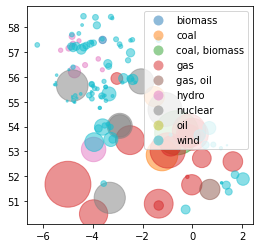

In [43]:
gdf_map = df_to_gdf(df_map)
gdf_map_latest = gdf_map.assign(output=gdf_map['output'].apply(lambda d: list(d.values())[-1]))

gdf_map_latest.plot(markersize='output', column='fuel_type', alpha=0.5, legend=True)

In [44]:
#exports
def construct_map_geojson(
    df_PN, 
    df_powerdict,
    n_SPs=48*7
):
    osuked_id_mappings = construct_osuked_id_mappings(df_powerdict)
    osuked_id_to_bmu_ids, osuked_id_to_capacity_mw, osuked_id_to_fuel_type, osuked_id_to_name, osuked_id_to_lat_lon = osuked_id_mappings.values()

    df_map = construct_map_df(df_PN, osuked_id_to_bmu_ids, osuked_id_to_capacity_mw, osuked_id_to_lat_lon, osuked_id_to_fuel_type, osuked_id_to_name, n_SPs=n_SPs)
    gdf_map = df_to_gdf(df_map)

    geojson = json.loads(gdf_map.to_json())
    geojson['timeseries'] = [int(unix_datetime) for unix_datetime in list(geojson['features'][0]['properties']['output'].keys())]

    return geojson

In [45]:
geojson = construct_map_geojson(df_PN, df_powerdict)

JSON(geojson)

<IPython.core.display.JSON object>

In [25]:
#exports
def save_map_geojson(geojson, fp='data/power_plants.json'):
    with open(fp, 'w') as f:
        json.dump(geojson, f)

In [26]:
save_map_geojson(geojson, fp='../data/power_plants.json')

In [27]:
#exports
def get_nearest_dt_idx(geojson, nearest_half_hour):
    ts = pd.to_datetime([x*1000000 for x in geojson['timeseries']]).tz_localize('UTC').tz_convert('Europe/London')
    nearest_hh_match = [i for i, dt in enumerate(ts) if dt==nearest_half_hour]
    
    if len(nearest_hh_match) == 1:
        return nearest_hh_match[0]
    else:
        return len(ts)-1
    
def generate_map_js(
    df_PN: pd.DataFrame, 
    df_powerdict: pd.DataFrame, 
    zoom: int=5,
    center: list=[54.8, -4.61],
    js_template_fp: str='templates/map.js', 
    js_docs_fp: str='docs/js/map.js',
    plants_geojson_fp: str='data/power_plants.json',
    plants_geojson_url: str='https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/power_plants.json',
    routes_geojson_url: str='https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/network_routes.json'
):
    geojson = construct_map_geojson(df_PN, df_powerdict)
    save_map_geojson(geojson, fp=plants_geojson_fp)
    
    nearest_half_hour = (pd.Timestamp.now().tz_localize('Europe/London')+pd.Timedelta(minutes=15)).round('30min')
    nearest_dt_idx = get_nearest_dt_idx(geojson, nearest_half_hour)
    
    rendered_map_js = Template(open(js_template_fp).read()).render(
        zoom=zoom,
        start_idx=nearest_dt_idx,
        center=center,
        plants_geojson_url=plants_geojson_url,
        routes_geojson_url=routes_geojson_url,
    )

    with open(js_docs_fp, 'w', encoding='utf8') as fp:
        fp.write(rendered_map_js)
        
    return

In [28]:
generate_map_js(df_PN, df_powerdict, plants_geojson_fp='../data/power_plants.json', js_template_fp='../templates/map.js', js_docs_fp='../docs/js/map.js')

In [29]:
# clean up the pop-up

In [30]:
#exports
def generate_map_md(md_template_fp='templates/map.md', md_docs_fp='docs/map.md'):
    update_date = pd.Timestamp.now().round('5min').tz_localize('Europe/London').strftime('%Y-%m-%d %H:%M')
    rendered_map_md = Template(open(md_template_fp).read()).render({'update_date': update_date})

    with open(md_docs_fp, 'w', encoding='utf8') as fp:
        fp.write(rendered_map_md)
        
    return

In [31]:
generate_map_md(md_template_fp='../templates/map.md', md_docs_fp='../docs/map.md')

In [32]:
#exports
app = typer.Typer()

<br>

`python -m ElexonDataPortal.dev.mapgen`

In [46]:
#exports
@app.command()
def generate_map(
    api_key: str=None,
    powerdict_url: str='https://raw.githubusercontent.com/OSUKED/Power-Station-Dictionary/main/data/output/power_stations.csv',
    js_template_fp: str='templates/map.js', 
    js_docs_fp: str='docs/js/map.js', 
    md_template_fp: str='templates/map.md', 
    md_docs_fp: str='docs/map.md',
    data_dir: str='data/PN',
    plants_geojson_fp: str='data/power_plants.json',
    plants_geojson_url: str='https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/power_plants.json',
    routes_geojson_url: str='https://raw.githubusercontent.com/OSUKED/ElexonDataPortal/master/data/network_routes.json'
):
    if api_key is None:
        assert 'BMRS_API_KEY' in os.environ.keys(), 'If the `api_key` is not specified during client initialisation then it must be set to as the environment variable `BMRS_API_KEY`'
        api_key = os.environ['BMRS_API_KEY']
            
    download_latest_PHYBM_data(api_key, data_dir)
    df_PN = load_most_recent_PN_data(data_dir)
    
    df_powerdict = pd.read_csv(powerdict_url)
    
    generate_map_js(df_PN, df_powerdict, js_template_fp=js_template_fp, js_docs_fp=js_docs_fp, plants_geojson_fp=plants_geojson_fp, plants_geojson_url=plants_geojson_url, routes_geojson_url=routes_geojson_url)
    generate_map_md(md_template_fp=md_template_fp, md_docs_fp=md_docs_fp)
    
    return 

In [49]:
generate_map(
    api_key=api_key,
    js_template_fp='../templates/map.js', 
    js_docs_fp='../docs/js/map.js', 
    md_template_fp='../templates/map.md', 
    md_docs_fp='../docs/map.md',
    data_dir='../data/PN',
    plants_geojson_fp='../data/power_plants.json'
)

In [ ]:
#exports
if __name__ == '__main__' and '__file__' in globals():
    app()

In [ ]:
#hide
from ElexonDataPortal.dev.nbdev import notebook2script
notebook2script('09-map-gen.ipynb')